In [1]:
import numpy as np
from scipy.optimize import minimize
from numpy.polynomial.chebyshev import Chebyshev
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

In [2]:
def generate_phi(degree):
    def f(x):
      S0 = 1.0
      e = 2.71828 
      K = 0.5
      fmax = 1.0
      return np.sqrt(S0 * np.exp(2 * np.log(e) - 2 * x) - K) / fmax
    
    def chebyshev_approximation(coeffs, x):
      P = Chebyshev(coeffs, domain=[-1, 1]) 
      return P(x)
    def objective_function(coeffs, x, target_func):
      return np.max(np.abs(target_func(x) - chebyshev_approximation(coeffs, x)))
    
    M = 100  # Number of grid points
    x_grid = np.linspace(-1, 1, M)  # Chebyshev grid
    initial_guess = np.zeros(degree)  # Degree 6 Chebyshev polynomials
    result = minimize(objective_function, initial_guess, args=(x_grid, f), method='BFGS')
    optimal_coeffs = result.x
    
    def chebyshev_to_phi(coeffs):
    # Convert from Chebyshev coefficients to QSP phase angles (adjust based on QSP protocol)
      phi_angles = np.arctan(coeffs) 
      return phi_angles

    phi_angles = chebyshev_to_phi(optimal_coeffs)
    return phi_angles


In [3]:
def u_sqrt_matrix(x, n):

    base_matrix = np.array([[np.sqrt(np.abs(x)), -np.sqrt(1 - np.abs(x))], 
                            [np.sqrt(1 - np.abs(x)), np.sqrt(np.abs(x))]])
    u_matrix = base_matrix
    for _ in range(n - 1):
        u_matrix = np.kron(u_matrix, base_matrix)
    return u_matrix

In [4]:
d=5
copy=d
phi_angles=generate_phi(d)
print(phi_angles)

[ 1.27727148 -1.26653578  0.61215852 -0.12244995  0.02093091]


In [5]:
def generate_qsp_sqrt(degree):

SyntaxError: incomplete input (1890424414.py, line 1)

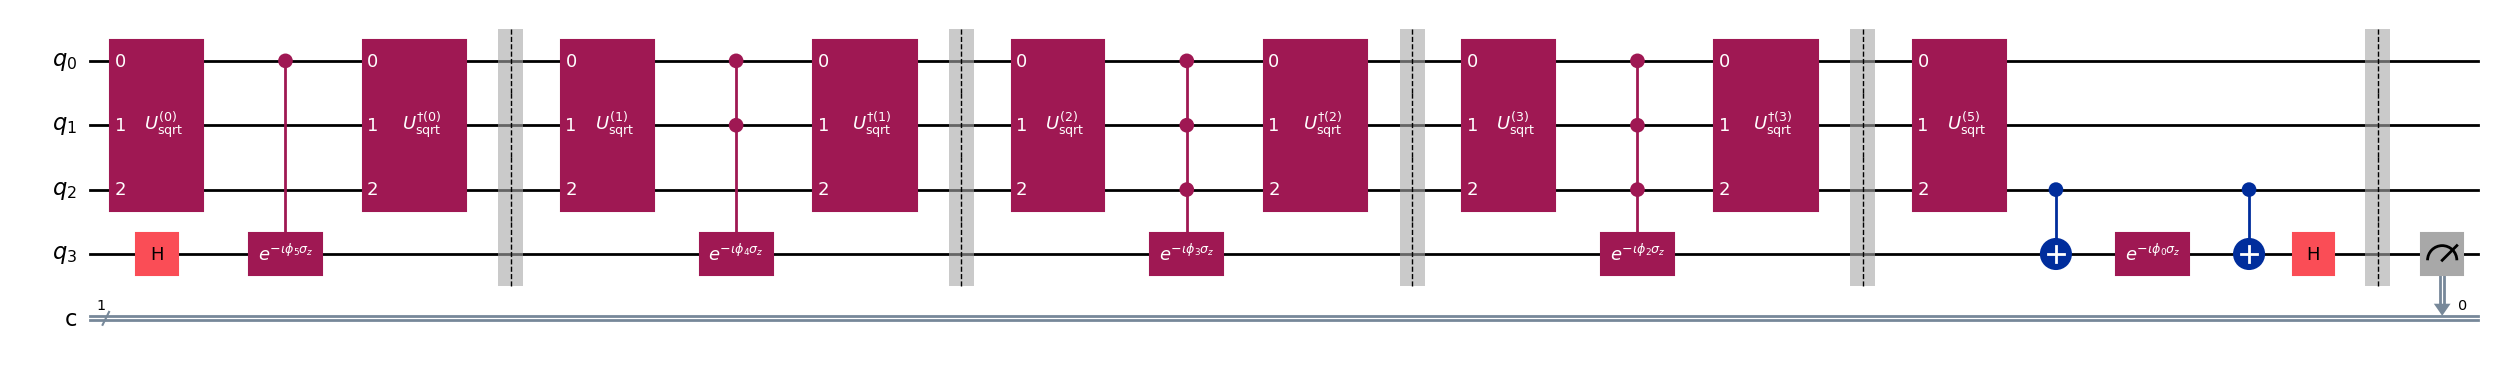

In [6]:
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 5%
T = 40 / 365  # 40 days to maturity

N=3
d=len(phi_angles)
# Calculate the parameters for the log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)

# Get the log-normal distribution parameters
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)
payoff_normalized = np.random.lognormal(mean=mu, sigma=sigma**2, size=N)
payoff_normalized /= np.max(payoff_normalized)

# Construct U_sqrt matrix
U_sqrt_matrix = u_sqrt_matrix(payoff_normalized.mean(), N)
U_sqrt = Operator(U_sqrt_matrix)

# Create quantum circuit
qc = QuantumCircuit(N + 1, 1)  # N qubits + 1 ancilla qubit for amplitude estimation

# Apply Hadamard to the ancilla qubit
qc.h(N)

# Apply the QSP unitaries with controlled phase rotations based on the optimized phi angles
for i in range(d):
    # Apply the U_sqrt unitary with appropriate labeling
    if i==d-1:
        break
    gate = UnitaryGate(U_sqrt_matrix, label=r"$U_{\text{sqrt}}^{(%d)}$" % i)
    qc.append(gate, qargs=range(N))

    # Controlled phase rotation on the ancilla qubit, based on phi_d
    phi_d = phi_angles[i % len(phi_angles)]  # Use the optimized QSP phases
    controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (d - i))

    # Ensure control qubits do not overlap with the ancilla qubit
    control_qubits = list(range(min(i + 1, N)))
    qc.append(controlled_phase.control(len(control_qubits)), qargs=control_qubits + [N])

    # Apply the inverse of U_sqrt with explicit dagger label
    inv_gate = UnitaryGate(U_sqrt_matrix.T.conj(), label=r"$U_{\text{sqrt}}^{\dag(%d)}$" % i)
    qc.append(inv_gate, qargs=range(N))

    qc.barrier()

d=copy
# If final case depends on d (e.g., d mod 2 check)
if d % 2 != 0:
    gate = UnitaryGate(U_sqrt_matrix, label=r"$U_{\text{sqrt}}^{(%d)}$" % (i+1))
    qc.append(gate, qargs=range(N))
    phi_d = phi_angles[i % len(phi_angles)]  # Modulo to avoid out-of-bounds access
    controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (d - i-1))

    # Ensure control qubits do not overlap with the ancilla qubit
    control_qubits = list(range(min(i + 1, N)))
    qc.cx(N-1,N)
    qc.append(controlled_phase, qargs=[N])
    qc.cx(N-1,N)

# Final Hadamard on the ancilla qubit
qc.h(N)

# Barrier and measurement
qc.barrier()
qc.measure(N, 0)

# Draw the circuit
qc.draw(output="mpl",fold=-1)

In [31]:
print(d)

7


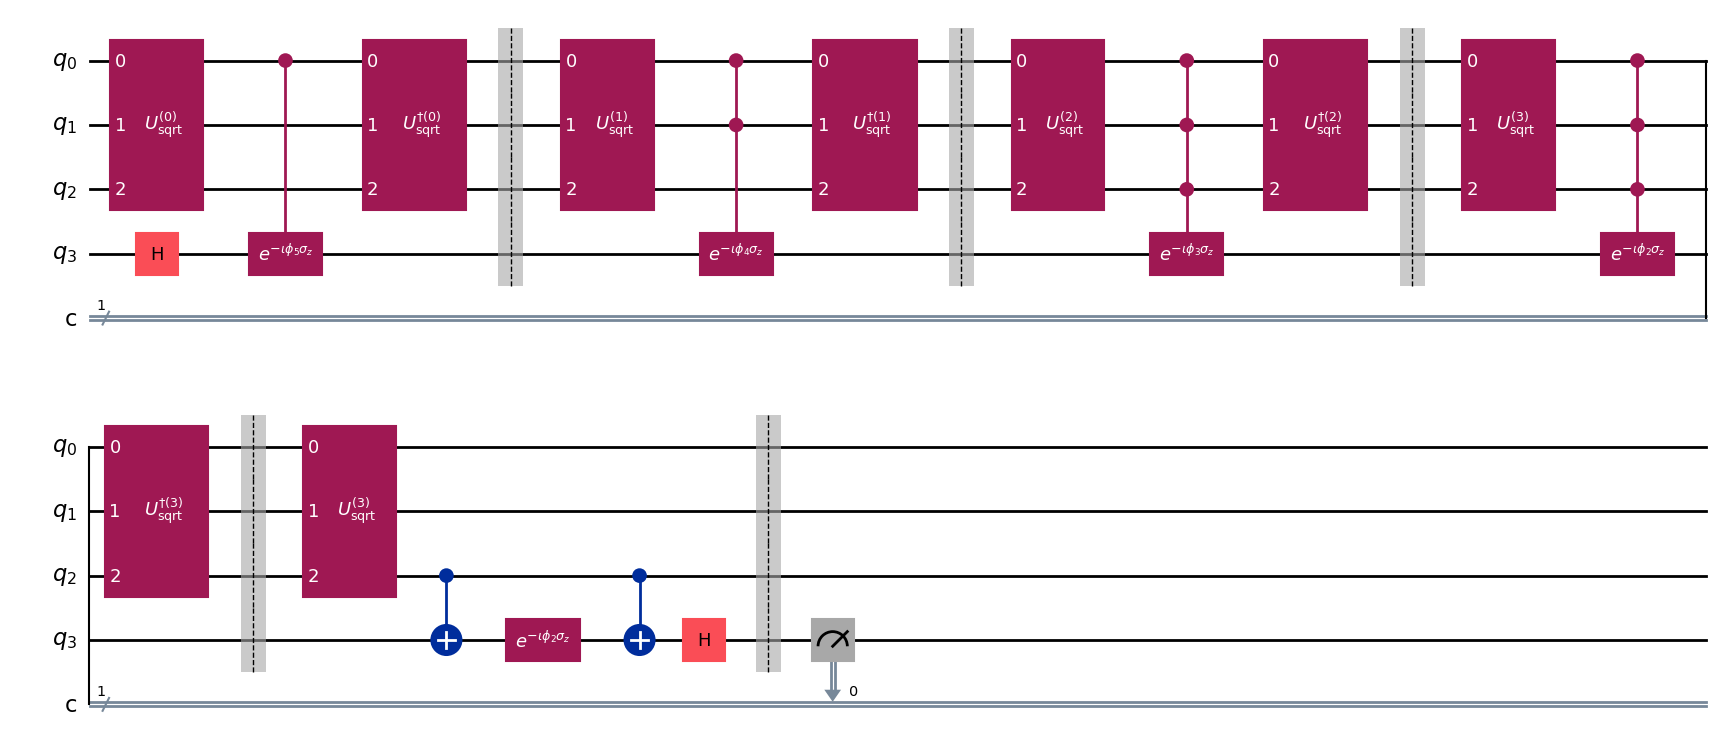

In [8]:
def generate_qsp_sqrt(degree):
    # Set parameters for log-normal distribution
    S = 2.0  # Initial spot price
    vol = 0.4  # Volatility of 40%
    r = 0.05  # Annual interest rate of 5%
    T = 40 / 365  # 40 days to maturity
    N = 3  # Number of qubits

    # Calculate parameters for the log-normal distribution
    mu = (r - 0.5 * vol**2) * T + np.log(S)
    sigma = vol * np.sqrt(T)

    # Generate normalized payoff
    payoff_normalized = np.random.lognormal(mean=mu, sigma=sigma, size=N)
    payoff_normalized /= np.max(payoff_normalized)

    # Construct U_sqrt matrix
    U_sqrt_matrix = u_sqrt_matrix(payoff_normalized.mean(), N)
    U_sqrt = Operator(U_sqrt_matrix)

    # Create quantum circuit
    qc = QuantumCircuit(N + 1, 1)  # N qubits + 1 ancilla qubit for amplitude estimation

    # Apply Hadamard to the ancilla qubit
    qc.h(N)

    # Assume phi_angles are defined or calculated prior to this function
    phi_angles = generate_phi(degree=degree)  # Example: evenly spaced angles

    # Apply the QSP unitaries with controlled phase rotations based on the optimized phi angles
    for i in range(degree):
        # Apply the U_sqrt unitary with appropriate labeling
        if i == degree - 1:
            break
        gate = UnitaryGate(U_sqrt_matrix, label=r"$U_{\text{sqrt}}^{(%d)}$" % i)
        qc.append(gate, qargs=range(N))

        # Controlled phase rotation on the ancilla qubit
        phi_d = phi_angles[i % len(phi_angles)]  # Use the optimized QSP phases
        controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (degree - i))

        # Ensure control qubits do not overlap with the ancilla qubit
        control_qubits = list(range(min(i + 1, N)))
        qc.append(controlled_phase.control(len(control_qubits)), qargs=control_qubits + [N])

        # Apply the inverse of U_sqrt with explicit dagger label
        inv_gate = UnitaryGate(U_sqrt_matrix.T.conj(), label=r"$U_{\text{sqrt}}^{\dag(%d)}$" % i)
        qc.append(inv_gate, qargs=range(N))

        qc.barrier()

    # Check for the final case based on degree
    if degree % 2 != 0:
        gate = UnitaryGate(U_sqrt_matrix, label=r"$U_{\text{sqrt}}^{(%d)}$" % (degree // 2 + 1))
        qc.append(gate, qargs=range(N))
        phi_d = phi_angles[(degree // 2) % len(phi_angles)]  # Modulo to avoid out-of-bounds access
        controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (degree // 2))

        # Ensure control qubits do not overlap with the ancilla qubit
        qc.cx(N-1,N)
        qc.append(controlled_phase, qargs=[N])
        qc.cx(N-1,N)

    # Final Hadamard on the ancilla qubit
    qc.h(N)

    # Barrier and measurement
    qc.barrier()
    qc.measure(N, 0)

    # Draw the circuit
    return qc

# Example of how to call the function
qc_sqrt=generate_qsp_sqrt(5)

qc_sqrt.draw(output="mpl")

In [9]:
def get_payoff(degree):
    S = 2.0  # initial spot price
    vol = 0.4  # volatility of 40%
    r = 0.05  # annual interest rate of 5%
    T = 40 / 365  # 40 days to maturity

    d=degree
# Calculate the parameters for the log-normal distribution
    mu = (r - 0.5 * vol**2) * T + np.log(S)
    sigma = vol * np.sqrt(T)

# Get the log-normal distribution parameters
    mean = np.exp(mu + sigma**2 / 2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)
    payoff_normalized = np.random.lognormal(mean=mu, sigma=sigma**2, size=N)
    payoff_normalized /= np.max(payoff_normalized)

    return payoff_normalized.mean()
get_payoff(3)

0.9828260214513059

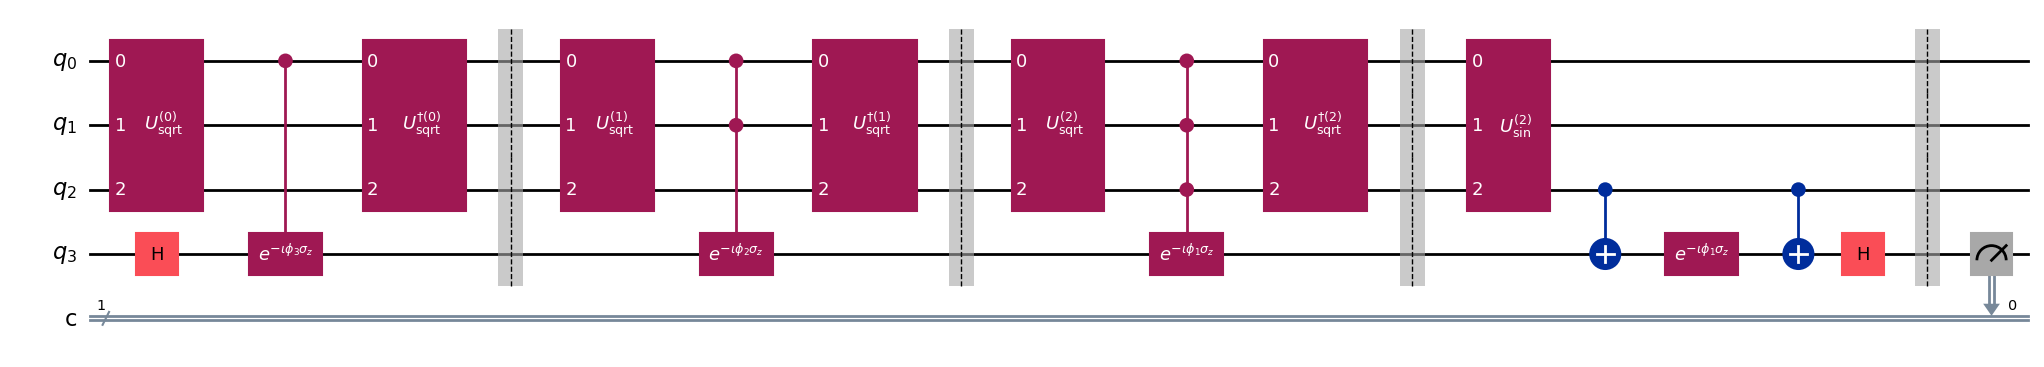

In [10]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator

def u_sin_theta_matrix(x, n):
    """
    Generates the U_sin(θ) unitary matrix for n qubits.
    
    Args:
        x (float): Angle parameter for U_sin.
        n (int): Number of qubits in the main register.
        
    Returns:
        np.array: Unitary matrix representing U_sin(θ).
    """
    base_matrix = np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
    u_matrix = base_matrix
    for _ in range(n - 1):
        u_matrix = np.kron(u_matrix, base_matrix)
    return u_matrix

def generate_qsp_circuit(degree, N, phi,payoff_normalized):
    """
    Generates a quantum circuit for QSP using both U_sqrt and U_sin.
    
    Args:
        degree (int): The number of repetitions in the QSP circuit.
        N (int): Number of qubits in the main register.
        payoff_normalized (np.array): Normalized payoff data for constructing U_sqrt.
        
    Returns:
        QuantumCircuit: The generated quantum circuit.
    """
    # Generate U_sqrt and U_sin matrices
    U_sqrt_matrix = u_sqrt_matrix(payoff_normalized.mean(), N)
    theta = payoff_normalized.mean()  # Example angle for U_sin
    U_sin_matrix = u_sin_theta_matrix(theta, N)

    # Create quantum circuit
    qc = QuantumCircuit(N + 1, 1)  # N qubits + 1 ancilla qubit for amplitude estimation

    # Apply Hadamard to the ancilla qubit
    qc.h(N)

    # Generate random phase angles for controlled phase rotations
    phi = np.random.uniform(-np.pi, np.pi, size=degree)

    # Apply QSP unitaries for degree times
    for i in range(degree):
        # Apply U_sqrt unitary
        sqrt_gate = UnitaryGate(U_sqrt_matrix, label=r"$U_{\text{sqrt}}^{(%d)}$" % i)
        qc.append(sqrt_gate, qargs=range(N))

        # Controlled phase rotation on the ancilla qubit
        phi_d = phi[i % len(phi)]  # Use modulo to avoid out-of-bounds access
        controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (degree - i))
        control_qubits = list(range(min(i + 1, N)))  # Control qubits should not include the ancilla
        qc.append(controlled_phase.control(len(control_qubits)), qargs=control_qubits + [N])

        # Apply the inverse of U_sqrt
        inv_sqrt_gate = UnitaryGate(U_sqrt_matrix.T.conj(), label=r"$U_{\text{sqrt}}^{\dag(%d)}$" % i)
        qc.append(inv_sqrt_gate, qargs=range(N))

        qc.barrier()

    # Final application of U_sin and controlled phase if degree is odd
    if degree % 2 != 0:
        sin_gate = UnitaryGate(U_sin_matrix, label=r"$U_{\sin}^{(%d)}$" % (degree // 2 + 1))
        qc.append(sin_gate, qargs=range(N))
        phi_d = phi[(degree // 2) % len(phi)]  # Avoid out-of-bounds
        qc.cx(N-1,N)
        controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (degree // 2))

        # Control qubits for the final case
        qc.append(controlled_phase, qargs=[N])
        qc.cx(N-1,N)

    # Final Hadamard on the ancilla qubit
    qc.h(N)

    # Barrier and measurement
    qc.barrier()
    qc.measure(N, 0)

    return qc

# Example parameters for usage
N = 3  # Number of qubits
degree = 3  # The number of repetitions
phi = generate_phi(degree=degree)  # Example normalized payoff data

# Generate the quantum circuit
qsp_circuit = generate_qsp_circuit(degree, N, phi,payoff_normalized=get_payoff(degree))

# Draw the circuit
qsp_circuit.draw(output="mpl", fold=-1)


In [11]:
N=3
def get_payoff(degree):
    S = 2.0  # initial spot price
    vol = 0.4  # volatility of 40%
    r = 0.05  # annual interest rate of 5%
    T = 40 / 365  # 40 days to maturity

    d=degree
# Calculate the parameters for the log-normal distribution
    mu = (r - 0.5 * vol**2) * T + np.log(S)
    sigma = vol * np.sqrt(T)

# Get the log-normal distribution parameters
    mean = np.exp(mu + sigma**2 / 2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)
    payoff_normalized = np.random.lognormal(mean=mu, sigma=sigma**2, size=N)
    payoff_normalized /= np.max(payoff_normalized)

    return payoff_normalized.mean()
get_payoff(5)

0.9918130879445544

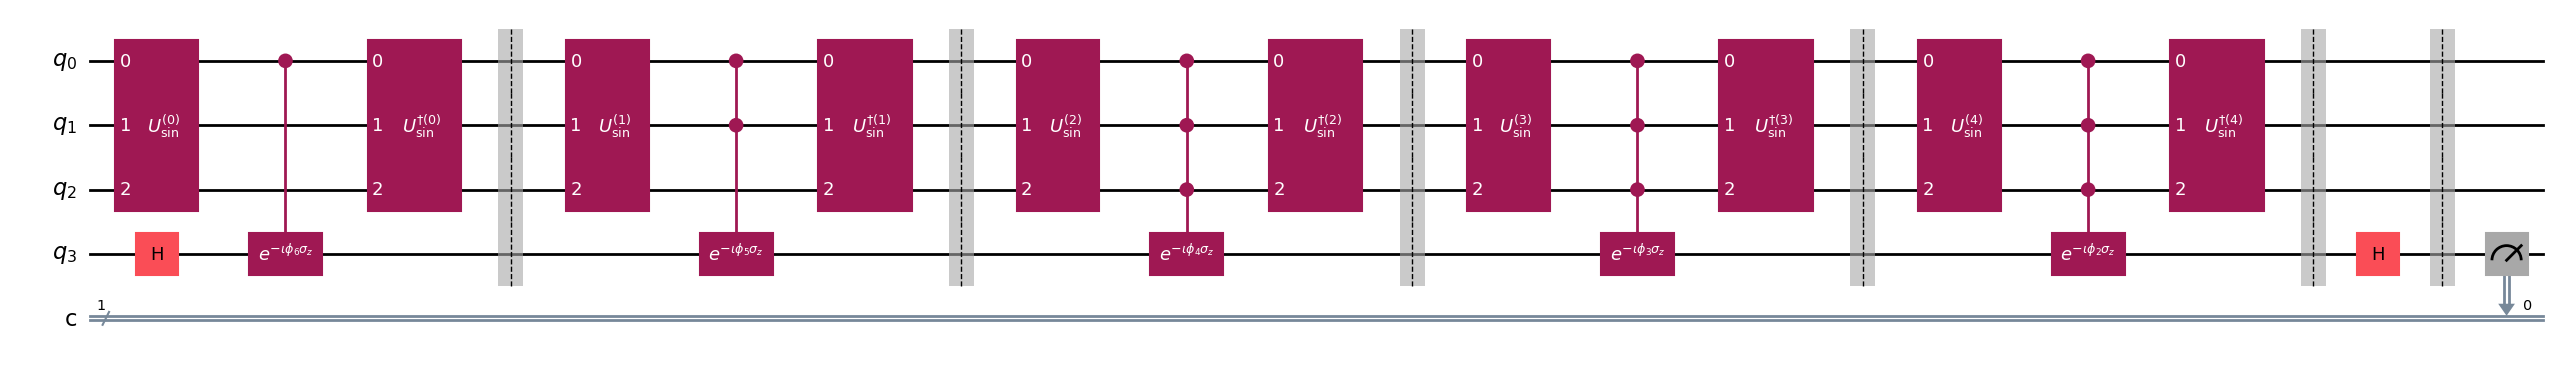

In [16]:
# Function to generate U_sin(θ) matrix
def u_sin_theta_matrix(x, n):
    """
    Generates the U_sin(θ) unitary matrix for n qubits.
    
    Args:
        x (float): Angle parameter for U_sin.
        n (int): Number of qubits in the main register.
        
    Returns:
        np.array: Unitary matrix representing U_sin(θ).
    """
    base_matrix = np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
    u_matrix = base_matrix
    for _ in range(n - 1):
        u_matrix = np.kron(u_matrix, base_matrix)
    return u_matrix

# Example parameters for European Call Option pricing using QSP
N = 3  # Number of qubits in the main register (for example)
d = 6 # The number of repetitions depends on # Example angle parameter for U_sin
payoff_normalized = get_payoff(degree=d) # Example normalized payoff data
U_sin_matrix = u_sin_theta_matrix(payoff_normalized, N)  # Generate U_sin
phi = generate_phi(degree=d) # Random phase angles

# Create the quantum circuit
qc_sin = QuantumCircuit(N + 1, 1)  # N qubits + 1 ancilla qubit for amplitude estimation

# Apply Hadamard to the ancilla qubit
qc_sin.h(N)

# Apply the QSP unitaries with controlled phase rotations exactly d times
for i in range(d):
    if i==d-1: break;
    # Apply the U_sin unitary with appropriate labeling
    gate = UnitaryGate(U_sin_matrix, label=r"$U_{\sin}^{(%d)}$" % i)
    qc_sin.append(gate, qargs=range(N))

    # Controlled phase rotation on the ancilla qubit, based on phi_d
    phi_d = phi[i % len(phi)]  # Modulo ensures we don't exceed the length of phi
    controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (d-i))
    
    # Ensure no overlap on qubits (control qubits should not include the ancilla qubit)
    control_qubits = list(range(min(i + 1, N)))  # Control qubits are limited by N
    qc_sin.append(controlled_phase.control(len(control_qubits)), qargs=control_qubits + [N])

    # Apply the inverse of U_sin with an explicit dagger label
    inv_gate = UnitaryGate(U_sin_matrix.T.conj(), label=r"$U_{\sin}^{\dag(%d)}$" % i)
    qc_sin.append(inv_gate, qargs=range(N))

    qc_sin.barrier()

# If final case depends on d (use d mod 2 check)
if d % 2 != 0:
    gate = UnitaryGate(U_sqrt_matrix, label=r"$U_{\text{sin}}^{(%d)}$" % (i+1))
    qc_sin.append(gate, qargs=range(N))
    phi_d = phi[i % len(phi)]  # Modulo to avoid out-of-bounds access
    controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (d - i))

    # Ensure control qubits do not overlap with the ancilla qubit
    control_qubits = list(range(min(i + 1, N)))
    qc_sin.cx(N-1,N)
    qc_sin.append(controlled_phase, qargs=[N])
    qc_sin.cx(N-1,N)

# Final Hadamard on the ancilla qubit
qc_sin.h(N)

# Barrier and measurement
qc_sin.barrier()
qc_sin.measure(N, 0)

# Draw the circuit
qc_sin.draw(output="mpl",fold=-1)

In [15]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit import transpile 
from qiskit.visualization import plot_histogram

backend=GenericBackendV2(num_qubits=5)

def get_probs(qc):
    simulator = GenericBackendV2(num_qubits=N+1)
    compiled = transpile(qc,simulator)
    job=simulator.run(compiled,shots=8192)
    result = job.result()
    counts = result.get_counts(qc)

    # Extract the probability of measuring '1' in the ancilla qubit
    probability_of_one = counts.get('1', 0) / 1024

    return probability_of_one

In [14]:
import matplotlib.pyplot as plt 
import numpy as np

In [ ]:
imp

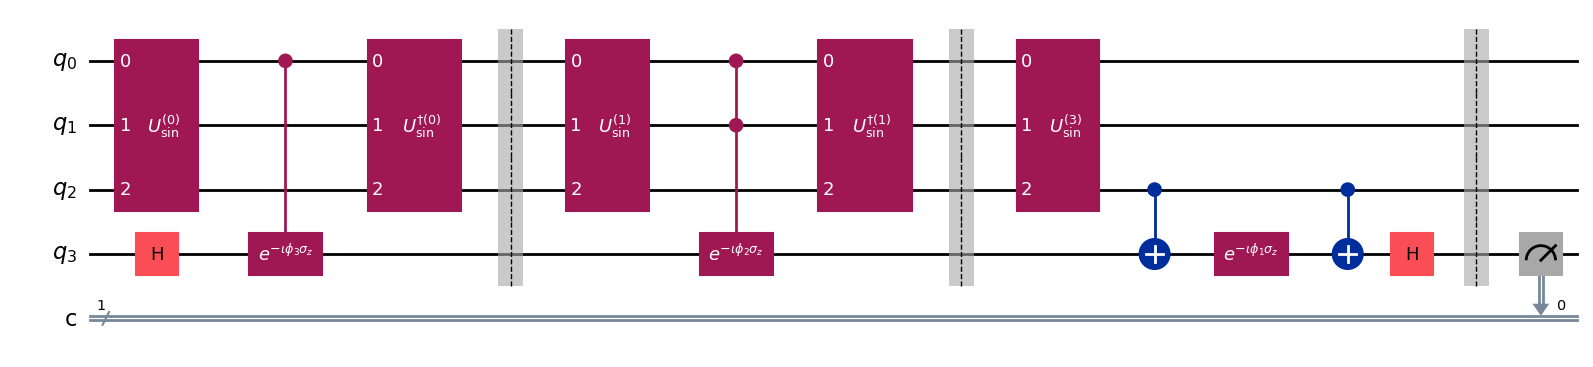

In [22]:
def evaluate_qsp_sin_circuit(N, d):
    N = N  # Number of qubits in the main register (for example)
    d = d# The number of repetitions depends on # Example angle parameter for U_sin
    payoff_normalized = get_payoff(degree=d) # Example normalized payoff data
    U_sin_matrix = u_sin_theta_matrix(payoff_normalized, N)  # Generate U_sin
    phi = generate_phi(degree=d) # Random phase angles

# Create the quantum circuit
    qc_sin = QuantumCircuit(N + 1, 1)  # N qubits + 1 ancilla qubit for amplitude estimation

# Apply Hadamard to the ancilla qubit
    qc_sin.h(N)

# Apply the QSP unitaries with controlled phase rotations exactly d times
    for i in range(d):
      if i==d-1: 
        break;
    # Apply the U_sin unitary with appropriate labeling
      gate = UnitaryGate(U_sin_matrix, label=r"$U_{\sin}^{(%d)}$" % i)
      qc_sin.append(gate, qargs=range(N))

    # Controlled phase rotation on the ancilla qubit, based on phi_d
      phi_d = phi[i % len(phi)]  # Modulo ensures we don't exceed the length of phi
      controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (d-i))
    
    # Ensure no overlap on qubits (control qubits should not include the ancilla qubit)
      control_qubits = list(range(min(i + 1, N)))  # Control qubits are limited by N
      qc_sin.append(controlled_phase.control(len(control_qubits)), qargs=control_qubits + [N])

    # Apply the inverse of U_sin with an explicit dagger label
      inv_gate = UnitaryGate(U_sin_matrix.T.conj(), label=r"$U_{\sin}^{\dag(%d)}$" % i)
      qc_sin.append(inv_gate, qargs=range(N))

      qc_sin.barrier()

# If final case depends on d (use d mod 2 check)
    if d % 2 != 0:
      gate = UnitaryGate(U_sqrt_matrix, label=r"$U_{\text{sin}}^{(%d)}$" % (i+1))
      qc_sin.append(gate, qargs=range(N))
      phi_d = phi[i % len(phi)]  # Modulo to avoid out-of-bounds access
      controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (d - i))

    # Ensure control qubits do not overlap with the ancilla qubit
      control_qubits = list(range(min(i + 1, N)))
      qc_sin.cx(N-1,N)
      qc_sin.append(controlled_phase, qargs=[N])
      qc_sin.cx(N-1,N)

# Final Hadamard on the ancilla qubit
    qc_sin.h(N)

# Barrier and measurement
    qc_sin.barrier()
    qc_sin.measure(N, 0)

    # Simulate the circuit
    simulator = GenericBackendV2(num_qubits=10)
    compiled = transpile(qc,simulator)
    job=simulator.run(compiled,shots=8192)
    result = job.result()
    counts = result.get_counts(qc)

    # Extract the probability of measuring '1' in the ancilla qubit
    probability_of_one = counts.get('1', 0) / 1024

    return qc_sin,probability_of_one

qc,_=evaluate_qsp_sin_circuit(3,3)
qc.draw("mpl")

In [25]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager